# Time Series Analysis on a Driverless AI Model

In [1]:
import requests
import math
import os
import pandas as pd
from h2oai_client import Client, ModelParameters, InterpretParameters
from sklearn.model_selection import train_test_split
from subprocess import Popen, PIPE
from dateutil.parser import parse
import datetime

In [2]:
%matplotlib inline
import matplotlib
from matplotlib.ticker import FuncFormatter
import seaborn
import numpy as np
import matplotlib.pyplot as plt

## Download Walmart Weekly Sales Data

For this notebook we are using the Kaggle Walmart Sales Forecasting challenge. You can download the data here:
https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data#

Here is a description of the features in the dataset:
```
Store - the store number
Date - the week
Dept - the department number
Weekly_Sales -  sales for the given department in the given store
IsHoliday - whether the week is a special holiday week
Temperature - average temperature in the region
Fuel_Price - cost of fuel in the region
MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. 
CPI - the consumer price index
Unemployment - the unemployment rate
IsHoliday - whether the week is a special holiday week
```


In [3]:
path = 'data/walmart_train.csv.bz2'
process = Popen(['bzip2', '-d', path], stdout=PIPE, stderr=PIPE)
stdout, stderr = process.communicate()

## Write train and test set to disk for later use in DAI

In [3]:
train_path = "data/walmart_train.csv"
walmart_df = pd.read_csv(train_path)
time1_path = "data/walmart_time1.csv"
time2_path = "data/walmart_time2.csv"
split_date = "2011-07-01"
time1_pd = walmart_df.loc[walmart_df.Date < split_date] #Split data by time
time2_pd = walmart_df.loc[walmart_df.Date >= split_date]
if not (os.path.isfile(time1_path) and os.path.isfile(time2_path)):
    time1_pd.to_csv(time1_path, index=False)
    time2_pd.to_csv(time2_path, index=False)

## Connect to Driverless AI

In [4]:
ip = 'localhost'
username = 'h2oai'
password = 'h2oai'
h2oai = Client(address = 'http://' + ip + ':12345', username = username, password = password)

## Upload data to Driverless AI

In [5]:
cwd = os.getcwd()
train_path_dai = cwd+"/data/walmart_time1.csv" #DAI needs absolute path
test_path_dai = cwd+"/data/walmart_time2.csv"  #DAI needs absolute path
train = h2oai.create_dataset_sync(train_path_dai)
test = h2oai.create_dataset_sync(test_path_dai)

## Set up parameters for Driverless AI experiment

In [6]:
#Set the parameters you want to pass to DAI
dataset_key=train.key #Dataset to use for DAI
validset_key='' #Validation set to use for DAI (Note, we are not using one for this experiment)
testset_key=test.key #Test set to use for DAI
target="Weekly_Sales" #Target column for DAI
dropped_cols=["sample_weight"] #List of columns to drop. In this case we are dropping 'sample_weight'
weight_col=None #The column that indicates the per row observation weights. 
                #If None, each row will have an observation weight of 1
fold_col=None #The column that indicates the fold. If None, the folds will be determined by DAI
time_col='Date' #Time Column: The column that provides a time order, if applicable.
                  #if [AUTO], Driverless AI will auto-detect a potential time order
                  #if [OFF], auto-detection is disabled
is_time_series=True #Whether or not the experiment is a time series problem
is_classification=False #Inform DAI if the problem type is a classification (binomial/multinomial) 
                    #or not (regression)
enable_gpus=True #Whether or not to enable GPUs
seed=1234 #Use seed for reproducibility
scorer_str='r2' #Set evaluation metric. In this case we are interested in optimizing R-squared
accuracy=7 #Accuracy setting for experiment (One of the 3 knobs you see in the DAI UI)
time=5 #Time setting for experiment (One of the 3 knobs you see in the DAI UI)
interpretability=2 #Interpretability setting for experiment (One of the 3 knobs you see in the DAI UI)
config_overrides=None #Extra parameters that can be passed in TOML format

For information on the experiment settings, refer to the [Experiment Settings](http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/launching.html#experimentsettings).

## Set time-series-specific settings
Here we choose the prediction horizon for our final model from the time series recipe. The horizon is a fixed window from which the time series model can output a valid prediction. The model can output intermediate predictions. Intermediate meaning the time between training+gap until the end of the horizon. To see more detail on how to choose and set the horizon please see:
http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/time-series-use-case.html

Since the horizon is fixed, it may be necessary to try multiple models with various horizons to choose the right model based on a balance of retraining frequency and
performance.

The gap period option is to simulate during training and validation, the time it takes to record or gather data. No predictions or data will be used from this gap period.

The numeric values here are in weeks, in accordance with the Walmart dataset.



In [7]:
# Note: horizon_in_weeks is how many weeks the model can predict out to. 
#       Intermediate weeks ARE predicted by the model
horizon_in_weeks = 39

# Gap between train dataset and when predictions will start
num_gap_periods = 0

## Launch experiment
Launch the experiment using the accuracy, time, and interpretability settings DAI suggested

In [ ]:
#experiment = h2oai.get_model_job('sapucota').entity # if your experiment is already done

experiment = h2oai.start_experiment_sync(
    
    #Datasets
    dataset_key=train.key, 
    validset_key = validset_key,
    testset_key=testset_key, 
    
    #Columns
    target_col=target,
    cols_to_drop=dropped_cols,
    weight_col=weight_col,
    fold_col=fold_col,
    orig_time_col=time_col,
    time_col=time_col,
    
    #Parameters
    is_classification=is_classification,
    enable_gpus=enable_gpus,
    seed=seed,
    accuracy=accuracy, #DAI suggested for accuracy
    time=time, #DAI suggested for time
    interpretability=interpretability, #DAI suggested for interpretability
    scorer=scorer_str,
    is_timeseries=is_time_series,
    #Time series parameters that need to be set but are not used as they are set to None/False
    time_groups_columns=['Date','Store', 'Dept'],   # The features used to group time series data together, 
                                                    # Each row would have a unique combination of these features
    time_period_in_seconds=3600*24*7*horizon_in_weeks,
    num_gap_periods=num_gap_periods,
    num_prediction_periods=1, # or 39 and dont * time_period_in_seconds by 39
    #Extra parameters that can be passed in TOML format
    config_overrides=None
)

View the final model score for the validation and test datasets. When feature engineering is complete, an ensemble model can be built depending on the accuracy setting. The experiment object also contains the score on the validation and test data for this ensemble model. In this case, the validation score is the score on the training cross-validation predictions.

In [11]:
print("Final Model Score on Validation Data: " + str(round(experiment.valid_score, 3)))
print("Final Model Score on Test Data: " + str(round(experiment.test_score, 3)))

Final Model Score on Validation Data: 0.95
Final Model Score on Test Data: 0.892


## Variable importance for Driverless AI experiment
The table outputted below shows the feature name, its relative importance, and a description. Some features will be engineered by Driverless AI and some can be the original feature.

The DAI Time Series recipe uses time based transformations such as Lags which are past values of a numeric features. You may also see EWMA, this is the Exponentionally Weighted Moving Average transformation on historical values of a particular numeric feature. This transformation calculates the change in a variable over a period of time and decays that change over a longer period.

In [12]:
#Download Summary
import subprocess
summary_path = h2oai.download(src_path=experiment.summary_path, dest_dir=".")
dir_path = "./h2oai_experiment_summary_" + experiment.key
subprocess.call(['unzip', '-o', summary_path, '-d', dir_path], shell=False)

#View Features
features = pd.read_table(dir_path + "/features.txt", sep=',', skipinitialspace=True)
features.head(n=30)

,Relative Importance,Feature,Description
0,1.000000,42_EWMA(0.05)(0)TargetLags:Dept:Store.1:2,"EWMA (α = 0.05) of target lags [1, 2] grouped ..."
1,0.081583,25_EWMA(0.05)(0)TargetLags:Dept.1:2,"EWMA (α = 0.05) of target lags [1, 2] grouped ..."
2,0.073816,116_ClusterDist8:Dept.1,Distances to cluster center after segmenting c...
3,0.068951,8_TargetLag:Store.1,Lag of target for groups ['Store'] by 1 time p...
4,0.065496,26_EWMA(0.05)(0)TargetLags:Store.1:2,"EWMA (α = 0.05) of target lags [1, 2] grouped ..."
5,0.063677,117_ClusterDist10:Dept.3,Distances to cluster center after segmenting c...
6,0.056677,1_Dept,Dept (original)
7,0.042125,21_ClusterDist5:Dept.4,Distances to cluster center after segmenting c...
8,0.041066,121_ClusterDist6:Dept.3,Distances to cluster center after segmenting c...
9,0.024420,80_ClusterDist9:Dept:Store.7,Distances to cluster center after segmenting c...


## Set up scoring package from Driverless AI experiment

In [13]:
h2oai.download(experiment.scoring_pipeline_path, '.')

'./scorer.zip'

In [14]:
%%capture
%%bash
#Unzip scoring package and install the scoring python library
unzip scorer;

In [15]:
#Import scoring module
!pip install scoring-pipeline/scoring_h2oai_experiment_*.whl

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
from scoring_h2oai_experiment_sapucota import Scorer #Make sure to add experiment name to  
                                                     #import scoring_h2oai_experiment_* 

In [17]:
%%capture
#Create a singleton Scorer instance.
#For optimal performance, create a Scorer instance once, and call score() or score_batch() multiple times.
scorer = Scorer()

## Make predictions

In [18]:

time1_pd["predict"] = scorer.score_batch(time1_pd)
time2_pd = time2_pd.reset_index(drop=True)
time2_pd["predict"] = scorer.score_batch(time2_pd)

/home/markc/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Make Shapley Values
Shapley values show the contribution of engineered features to the predicted weekly sales generated by the model.
Will Shapley values you can break down the components of a prediction and attribute precise values to specfic features. Please note, in some cases the model has a "link function" that yet to be applied to make the sum of the Shapley contributions equal to the prediction value.


In [19]:
train_and_test= time1_pd.append(time2_pd)
train_and_test = train_and_test.reset_index(drop=True)
shapley = scorer.score_batch(train_and_test, pred_contribs=True, fast_approx=True)

In [20]:
shapley.columns = [x.replace('contrib_','',1) for x in shapley.columns]

## Model Evaluation
Here we look at the overall model performance in test and train. We also show the model horizon window in red to illustrate the performance when the model is generating predictions beyond the horizon.
We prefer to use R-squared as the performance metric since the groups of Store and Department weekly sales are on vastly different scales.


In [21]:
from sklearn.metrics import r2_score, mean_squared_error

def r2_rmse( g ):
    r2 = r2_score( g['Weekly_Sales'], g['predict'] )
    rmse = np.sqrt( mean_squared_error( g['Weekly_Sales'], g['predict'] ) )
    return pd.Series( dict(  r2 = r2, rmse = rmse ) )

metrics_ts = train_and_test.groupby( 'Date' ).apply( r2_rmse )
metrics_ts.index = [parse(x) for x in metrics_ts.index]

### R2 Time Series Plot
This would be a useful plot to compare R2 over time between different DAI time series models each with different prediction horizons

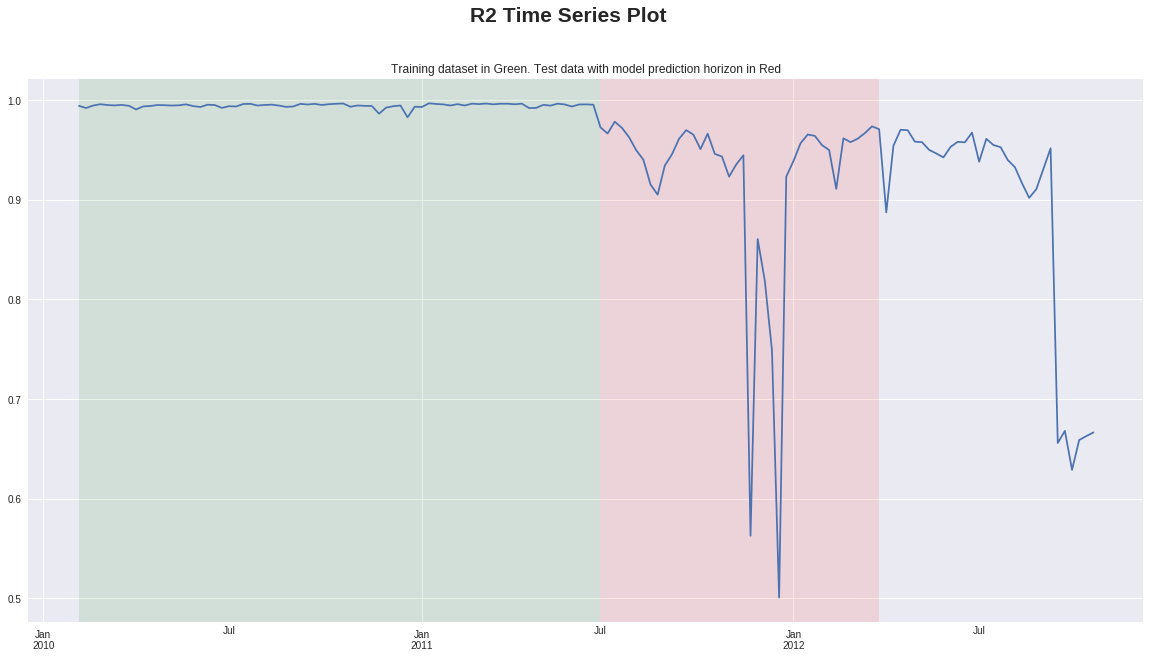

In [22]:
metrics_ts['r2'].plot(figsize=(20,10), title=("Training dataset in Green. Test data with model prediction horizon in Red"))


test_window_start = str(parse(time2_pd["Date"].min()) + datetime.timedelta(weeks=num_gap_periods))
test_window_end = str(parse(test_window_start) + datetime.timedelta(weeks=horizon_in_weeks))


plt.axvspan(time2_pd["Date"].min(), test_window_end, facecolor='r', alpha=0.1)
plt.axvspan(time1_pd["Date"].min(), test_window_start, facecolor='g', alpha=0.1)
plt.suptitle("R2 Time Series Plot",  fontsize=21, fontweight='bold')
plt.show()

### Worst and Best Groups
Here we generate the best and worst groups by R2. We filter out groups that have some missing data. We only calculate R2 within the valid test horizon window.

In [23]:
avg_count = train_and_test.groupby(["Store","Dept"]).size().mean()
print("average count: " + str(avg_count))
train_and_test_filtered = train_and_test.groupby(["Store","Dept"]).filter(lambda x: len(x) > 0.8 * avg_count)
train_and_test_filtered = train_and_test_filtered.loc[(train_and_test_filtered.Date < test_window_end) &
                                                     (train_and_test_filtered.Date > test_window_start)]

average count: 126.55959171419994


In [24]:
grouped_r2s = train_and_test_filtered.groupby(["Store","Dept"]).apply( r2_rmse ).sort_values("r2")

In [25]:
print(grouped_r2s.head()) # worst groups
print(grouped_r2s.tail()) # best groups

                    r2        rmse
Store Dept                        
36    25   -875.369989  179.457548
30    25   -578.258849  330.426116
      6    -301.603758  184.744816
33    55   -288.292147  356.027698
44    25   -155.622057  208.824666
                  r2         rmse
Store Dept                       
24    95    0.623023  7477.778263
26    9     0.637832  3815.845180
21    92    0.680821  2044.332115
40    12    0.720645   638.495601
26    12    0.746886   673.880181


## Choose group

In [144]:
# Choose Group
store_num = 26
dept_num = 12
date_selection = '2012-02-10'

## Plot Actual vs Predicted

In [145]:

plot_df = train_and_test[(train_and_test.Store == store_num) & (train_and_test.Dept == dept_num)][["Date","Weekly_Sales","predict"]]
plot_df["Date"] = plot_df["Date"].apply(lambda x: parse(x))
plot_df = plot_df.set_index("Date")

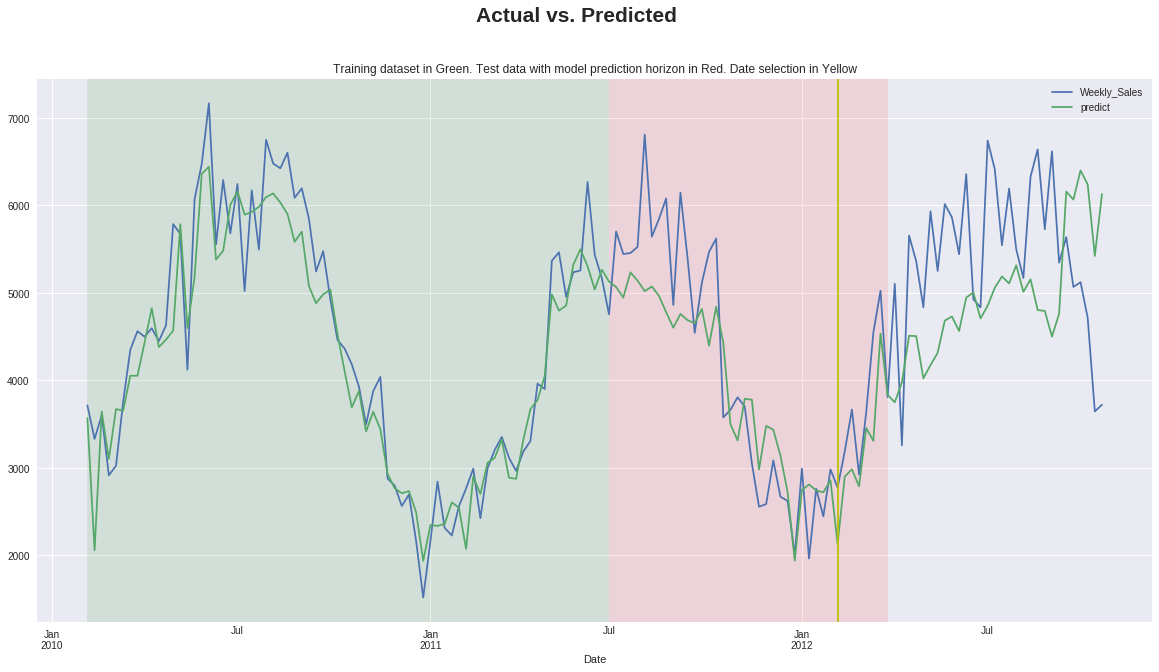

In [146]:
plot_df.plot(figsize=(20,10), title=("Training dataset in Green. Test data with model prediction horizon in Red. Date selection in Yellow"))

plt.axvspan(time2_pd["Date"].min(), test_window_end, facecolor='r', alpha=0.1)
plt.axvspan(time1_pd["Date"].min(), test_window_start, facecolor='g', alpha=0.1)
plt.axvline(x=date_selection, color='y')
plt.suptitle("Actual vs. Predicted", fontsize=21, fontweight='bold')
plt.show()

## Plot Shapley
This is a global vs local Shapley plot, with global being the average Shapley values for all of the predictions in the selected group and local being the Shapley value for that specific prediction. Looking at this plot can give clues as to which features contributed to the error in the prediction.

In [147]:
shap_vals_group = shapley.loc[(train_and_test.Store==store_num) & (train_and_test.Dept==dept_num),:]
shap_vals_timestamp = shapley.loc[(train_and_test.Store==store_num) 
                                  & (train_and_test.Dept==dept_num)
                                  & (train_and_test.Date==date_selection),:]
shap_vals = shap_vals_group.mean()
shap_vals = pd.concat([pd.DataFrame(shap_vals), shap_vals_timestamp.transpose()], axis=1, ignore_index=True)
shap_vals = shap_vals.sort_values(by=0)
bias = shap_vals.loc["bias",0]
shap_vals = shap_vals.drop("bias",axis=0)
shap_vals.columns = ["Global (Group)", "Local (Timestamp)"]



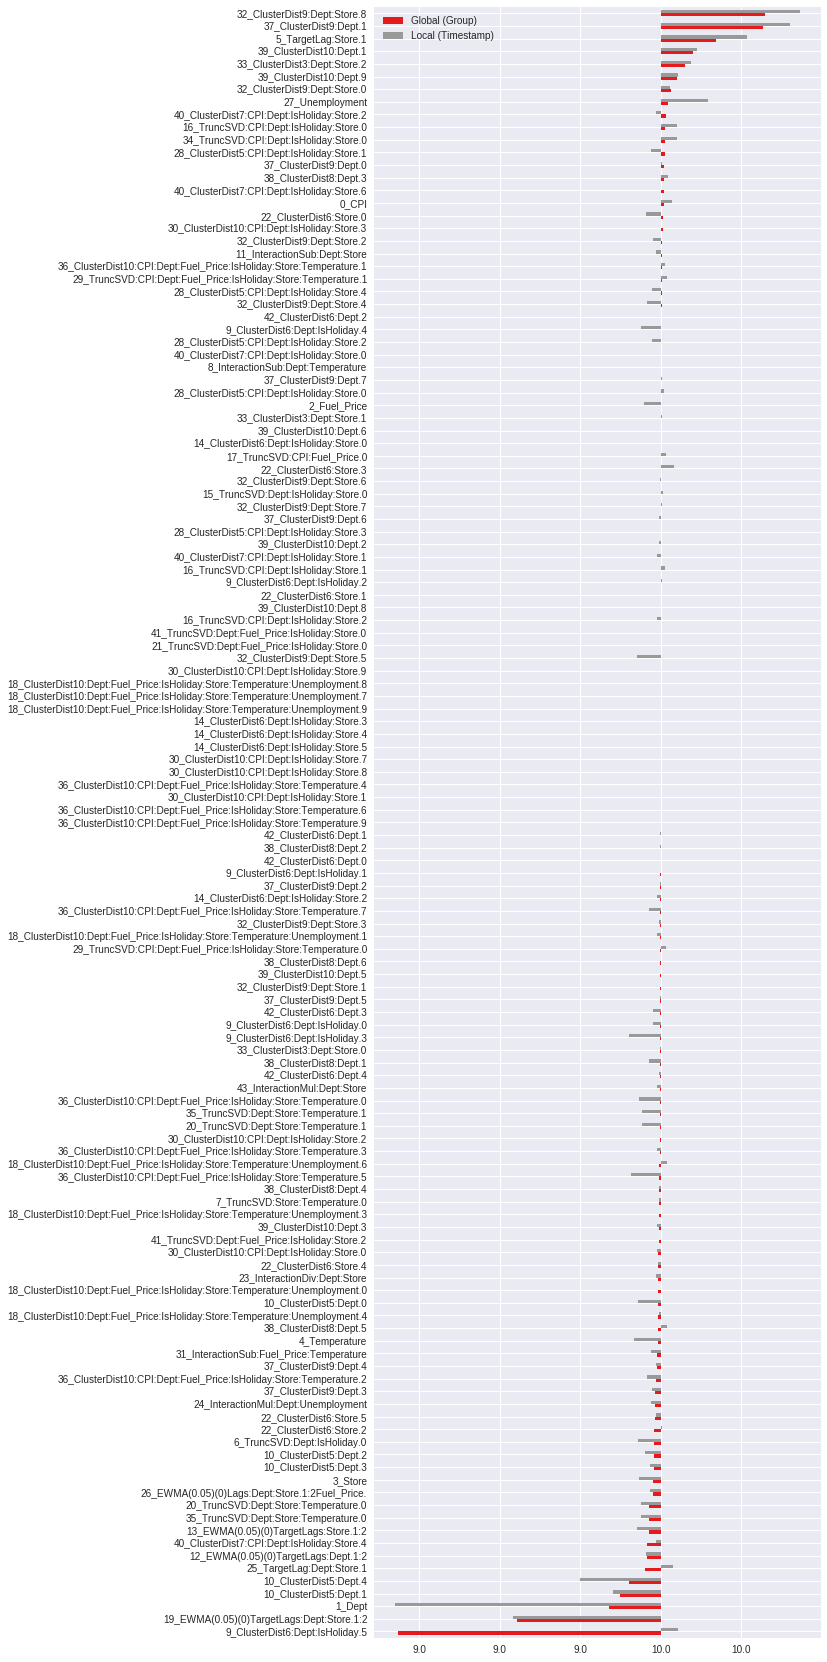

In [148]:
formatter = FuncFormatter(lambda x, y:  str(round(float(x) + bias)))
ax = shap_vals.plot.barh(figsize=(8,30), fontsize=10, colormap="Set1")
ax.xaxis.set_major_formatter(formatter)
plt.show()


## Summary
This notebook should get you started with all you need to diagnose and debug time series models from DAI.  Try different horizons during training and compare the model's R2 over time to pick the best horizon for your use case.  Use the actual vs prediction plots to do detailed debugging. Find some interesting dates to examine and use the Shapley plots to see how the features impacted the final prediction.